# Generate full emissions portfolio from projected Kyoto gas baskets
Updated to include announcements as of COP26, 5/11/21. Including an analysis of full impact of Net Zero commitments on emissions.
# Part 1: load and harmonise data

In [1]:
import sys
stdout = sys.stdout

In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pyam
import re
import seaborn as sns
from scipy.interpolate import interp1d, PchipInterpolator

<IPython.core.display.Javascript object>

In [3]:
from silicone.time_projectors import ExtendLatestTimeQuantile
import silicone.multiple_infillers as mi
import silicone.database_crunchers as dc
from silicone.utils import convert_units_to_MtCO2_equiv, _construct_consistent_values

# Import the data

In [4]:
co2 = "Emissions|CO2"
co2ind = "Emissions|CO2|Energy and Industrial Processes"
co2afolu = "Emissions|CO2|AFOLU"
variable = "Emissions|Kyoto Gases (AR5-GWP100)"
metric = "AR5GWP100"
kyexaf = variable + "|Excluding CO2 AFOLU"
unit = "Mt CO2-equiv/yr"
co2unit = "Mt CO2/yr"
years = [2010, 2015, 2020, 2030] + list(range(2010, 2101, 10))

In [5]:
# Do we want to filter databases only for some types of scenarios? 
scenstring = "*"

In [6]:
out_folder = "../output/processed_files/"
# We have updated from using the SR1.5 database to AR6 but I haven't updated the names yet!
sr15 = pyam.IamDataFrame("../input/AR6_Scenarios_Database_World_v1.0_emissions.csv")

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ..\input\AR6_Scenarios_Database_World_v1.0_emissions.csv


In [7]:
# Import data on expected projection of emissions
version = "v6"
readin_data = pd.read_excel(
    "../input/global_ite4_allmodels_emissions_ext.xlsx", sheet_name="Sheet1")

In [8]:
# Import data on expected projection of emissions
orig_gemini = []
kygemname = "GEMINI_E3 from Kyoto"
for sheet in ["LTS", "CP_EI", "NDC_EI"]:
    orig_gemi = pd.read_excel("../input/Extrapolated_Scenario_GEMINI-E3-15082022.xlsx", sheet_name=sheet)
    orig_gemi["year"] = orig_gemi["Unnamed: 0"]
    orig_gemi["value"] = orig_gemi["World"]
    orig_gemi = orig_gemi.loc[:, ["year", "value"]]
    orig_gemi["model"] = kygemname
    orig_gemi["scenario"] = sheet
    orig_gemi["variable"] = variable
    orig_gemi["region"] = "World"
    orig_gemi["unit"] = unit
    orig_gemini.append(orig_gemi)
orig_gemini = pyam.IamDataFrame(pd.concat(orig_gemini))
orig_gemini.data

,model,scenario,region,variable,unit,year,value
0,GEMINI_E3 from Kyoto,CP_EI,World,Emissions|Kyoto Gases (AR5-GWP100),Mt CO2-equiv/yr,2020,49705.656903
1,GEMINI_E3 from Kyoto,CP_EI,World,Emissions|Kyoto Gases (AR5-GWP100),Mt CO2-equiv/yr,2030,50152.166909
2,GEMINI_E3 from Kyoto,CP_EI,World,Emissions|Kyoto Gases (AR5-GWP100),Mt CO2-equiv/yr,2040,46870.552258
3,GEMINI_E3 from Kyoto,CP_EI,World,Emissions|Kyoto Gases (AR5-GWP100),Mt CO2-equiv/yr,2050,42690.499183
4,GEMINI_E3 from Kyoto,CP_EI,World,Emissions|Kyoto Gases (AR5-GWP100),Mt CO2-equiv/yr,2060,39101.481867
5,GEMINI_E3 from Kyoto,CP_EI,World,Emissions|Kyoto Gases (AR5-GWP100),Mt CO2-equiv/yr,2070,36195.032440
6,GEMINI_E3 from Kyoto,CP_EI,World,Emissions|Kyoto Gases (AR5-GWP100),Mt CO2-equiv/yr,2080,33442.567774
7,GEMINI_E3 from Kyoto,CP_EI,World,Emissions|Kyoto Gases (AR5-GWP100),Mt CO2-equiv/yr,2090,30791.567882
8,GEMINI_E3 from Kyoto,CP_EI,World,Emissions|Kyoto Gases (AR5-GWP100),Mt CO2-equiv/yr,2100,28233.259392
9,GEMINI_E3 from Kyoto,LTS,World,Emissions|Kyoto Gases (AR5-GWP100),Mt CO2-equiv/yr,2020,49973.630445


In [9]:
readin_data

,Model,Scenario,Region,Variable,Unit,2005,2010,2015,2020,2025,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
0,GCAM-PR 5.3,Baseline,Brazil,Emissions|C2F6,kt C2F6/yr,0.058714,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,GCAM-PR 5.3,Baseline,Brazil,Emissions|CH4,Mt CH4/yr,18.281373,18.779554,20.481259,21.807881,22.395499,...,23.753591,23.493509,23.175625,22.846768,22.469740,22.049610,21.605284,21.147047,20.694788,20.237293
2,GCAM-PR 5.3,Baseline,Brazil,Emissions|CO,Mt CO/yr,38.680005,45.024700,50.463102,49.188982,48.548847,...,39.957675,39.332564,38.790260,38.325825,37.889210,37.520168,37.189988,36.894464,36.630231,36.392099
3,GCAM-PR 5.3,Baseline,Brazil,Emissions|CO2,Mt CO2/yr,948.168723,1044.559939,1434.384259,830.383517,737.114382,...,682.207572,663.747679,655.895677,640.556790,628.457292,633.569704,642.131846,637.917062,620.741735,596.136288
4,GCAM-PR 5.3,Baseline,Brazil,Emissions|CO2|AFOLU,Mt CO2/yr,589.900548,613.795319,922.685397,334.292141,208.702545,...,60.643254,31.942032,17.326598,-0.618592,-11.175121,-19.345632,-24.833823,-31.234715,-39.064938,-46.622961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109756,GCAM-PR 5.3,CP_EI,World,Emissions|OC,Mt OC/yr,32.332657,36.264409,37.608173,32.310538,31.036446,...,25.139991,23.764580,22.477666,21.226599,20.115790,19.049541,18.125434,17.289256,16.627250,16.093435
109757,GCAM-PR 5.3,CP_EI,World,Emissions|PFC,kt CF4-equiv/yr,9.699165,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
109758,GCAM-PR 5.3,CP_EI,World,Emissions|SF6,kt SF6/yr,5.360331,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
109759,GCAM-PR 5.3,CP_EI,World,Emissions|Sulfur,Mt SO2/yr,123.693433,114.947847,100.308096,96.388822,88.622812,...,53.249074,49.014778,45.251018,42.281704,39.612461,37.325239,35.408976,33.790038,32.334841,31.115332


In [10]:
readin_data = readin_data.replace({"Region": {"WORLD": "World"}, "Unit": {"MtCO2/yr": co2unit}})

In [11]:
raw_data = readin_data[(readin_data["Region"] == "World")].copy()
raw_data = pyam.IamDataFrame(raw_data).append(orig_gemini)
for year in [2015, 2020, 2025, 2035, 2045]:
    raw_data = raw_data.interpolate(year)
raw_data.timeseries()

2005  \
model         scenario region variable                                      unit                       
GCAM-PR 5.3   Baseline World  Emissions|C2F6                                kt C2F6/yr      2.098257   
                              Emissions|CH4                                 Mt CH4/yr     345.079687   
                              Emissions|CO                                  Mt CO/yr      853.245652   
                              Emissions|CO2                                 Mt CO2/yr   31425.936730   
                              Emissions|CO2|AFOLU                           Mt CO2/yr    1949.450263   
...                                                                                              ...   
TIAM_Grantham CP_EI    World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr   27424.007224   
              NDC_EI   World  Emissions|CO2|Energy                          Mt CO2/yr   25859.515600   
                              Emissions|CO2|Energy and Industrial Processes Mt CO2/yr   27424.007224   
              NDC_LTS  World  Emissions|CO2|Energy                          Mt CO2/yr   25859.515600   
                              Emissions|CO2|Energy and Industrial Processes Mt CO2/yr   27424.007224   

                                                                                                2010  \
model         scenario region variable                                      unit                       
GCAM-PR 5.3   Baseline World  Emissions|C2F6                                kt C2F6/yr      0.000000   
                              Emissions|CH4                                 Mt CH4/yr     367.571112   
                              Emissions|CO                                  Mt CO/yr      879.012250   
                              Emissions|CO2                                 Mt CO2/yr   36147.350059   
                              Emissions|CO2|AFOLU                           Mt CO2/yr    2479.748039   
...                                                                                              ...   
TIAM_Grantham CP_EI    World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr   30032.428147   
              NDC_EI   World  Emissions|CO2|Energy                          Mt CO2/yr   28082.534600   
                              Emissions|CO2|Energy and Industrial Processes Mt CO2/yr   30032.428147   
              NDC_LTS  World  Emissions|CO2|Energy                          Mt CO2/yr   28082.534600   
                              Emissions|CO2|Energy and Industrial Processes Mt CO2/yr   30032.428147   

                                                                                                2015  \
model         scenario region variable                                      unit                       
GCAM-PR 5.3   Baseline World  Emissions|C2F6                                kt C2F6/yr      0.000000   
                              Emissions|CH4                                 Mt CH4/yr     380.578724   
                              Emissions|CO                                  Mt CO/yr      878.106351   
                              Emissions|CO2                                 Mt CO2/yr   39196.367976   
                              Emissions|CO2|AFOLU                           Mt CO2/yr    3260.792355   
...                                                                                              ...   
TIAM_Grantham CP_EI    World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr   32303.673819   
              NDC_EI   World  Emissions|CO2|Energy                          Mt CO2/yr   30166.308850   
                              Emissions|CO2|Energy and Industrial Processes Mt CO2/yr   32303.673819   
              NDC_LTS  World  Emissions|CO2|Energy                          Mt CO2/yr   30166.308850   
                              Emissions|CO2|Energy and Industrial Processes Mt CO2/yr   32303.673819   

                                     

In [12]:
raw = pyam.IamDataFrame(raw_data)

In [13]:
# Import historical database
histall = pd.read_excel("../input/VanMarle2017Totals.xlsx", skiprows=1)
del histall["Unnamed: 13"]
del histall["Unnamed: 14"]
del histall["Unnamed: 15"]
histall = histall.rename(columns={"Scenario (History)": "Scenario"})
histall["Variable"] = histall["Variable"].str.replace("CMIP6 ", "")
histall["Scenario"] = "History"
histall["Region"] = histall["Region"].str.replace(".2", "").replace("R5OECD", "R5OECD90+EU")
histall = pyam.IamDataFrame(histall)

C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


In [14]:
kyoto_gases_oddly = [
        'Emissions|C2F6', 
        'Emissions|CF4',
        'Emissions|CH4',
        'Emissions|CO2',
        'Emissions|HFC',
        'Emissions|SF6',
        'Emissions|N2O'
]
fgases = ["Emissions|HFC", 'Emissions|PFC|C2F6', 'EmissionsPFC|CF4', 'Emissions|SF6']
pfcs = ['Emissions|PFC|C2F6', 'Emissions|PFC|CF4']
histkyoto = _construct_consistent_values(
    variable, 
    kyoto_gases_oddly, 
    convert_units_to_MtCO2_equiv(histall.filter(
        region="World", variable=kyoto_gases_oddly), metric_name=metric)
)
histall = histall.rename(variable={
    "Emissions|CF4":"Emissions|PFC|CF4", 'Emissions|C2F6':'Emissions|PFC|C2F6'})
histkyoto.timeseries()
histall = histall.append(histkyoto)
histnonafolu = histall.subtract(
    variable,
    co2afolu,
    name=kyexaf,
    ignore_units=True
)
histnonafolu = histnonafolu.data
histnonafolu["unit"] = unit
histnonafolu = pyam.IamDataFrame(histnonafolu)
histco2eni = histall.subtract(
    co2,
    co2afolu,
    name=co2ind,
    ignore_units=True
).data
histco2eni["unit"] = "Mt CO2/yr"
histco2eni = pyam.IamDataFrame(histco2eni)
histfgas = _construct_consistent_values(
    "Emissions|F-Gases", 
    fgases, 
    convert_units_to_MtCO2_equiv(
        histall.filter(region="World", variable=fgases), metric_name=metric)
)
histpfc = _construct_consistent_values(
    "Emissions|PFC", 
    pfcs, 
    convert_units_to_MtCO2_equiv(
        histall.filter(region="World", variable=pfcs), metric_name=metric)
)
histall = histall.append(histnonafolu).append(histco2eni).append(histfgas).append(histpfc)

In [15]:
# Ensure that the fgas totals work for the AR value we are using
fgas = "Emissions|F-Gases"
consistent_fgases = _construct_consistent_values(
    fgas, ["Emissions|SF6", "Emissions|PFC", "Emissions|HFC"], convert_units_to_MtCO2_equiv(
        histall.filter(variable=["Emissions|SF6", "Emissions|PFC*", "Emissions|HFC"]
                      ), metric_name=metric
    )
)
histall = histall.filter(variable=fgas, keep=False).append(consistent_fgases)

In [16]:
# We need to add data for the Kyoto-only GEMINI for the historic period
histKyGem = []
for scenario in raw_data.filter(model=kygemname).scenario:
    histKyGemi = histkyoto.filter(year=[2005, 2010, 2015]).rename(
        {"model": {histkyoto.model[0]: kygemname}, "scenario": {"History": scenario}})
    histKyGem.append(histKyGemi)
raw_data = raw_data.append(pyam.concat(histKyGem))

In [17]:
raw_data.filter(model=kygemname).timeseries()

2005  \
model                scenario region variable                           unit                            
GEMINI_E3 from Kyoto CP_EI    World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  46422.133404   
                     LTS      World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  46422.133404   
                     NDC_EI   World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  46422.133404   

                                                                                                 2010  \
model                scenario region variable                           unit                            
GEMINI_E3 from Kyoto CP_EI    World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  50141.447145   
                     LTS      World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  50141.447145   
                     NDC_EI   World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  50141.447145   

                                                                                                 2015  \
model                scenario region variable                           unit                            
GEMINI_E3 from Kyoto CP_EI    World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  54125.849662   
                     LTS      World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  54125.849662   
                     NDC_EI   World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  54125.849662   

                                                                                                 2020  \
model                scenario region variable                           unit                            
GEMINI_E3 from Kyoto CP_EI    World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  49705.656903   
                     LTS      World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  49973.630445   
                     NDC_EI   World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  49705.656903   

                                                                                                 2025  \
model                scenario region variable                           unit                            
GEMINI_E3 from Kyoto CP_EI    World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  49928.911906   
                     LTS      World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  48728.807541   
                     NDC_EI   World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  48594.819672   

                                                                                                 2030  \
model                scenario region variable                           unit                            
GEMINI_E3 from Kyoto CP_EI    World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  50152.166909   
                     LTS      World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  47483.984638   
                     NDC_EI   World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  47483.982442   

                                                                                                 2035  \
model                scenario region variable                           unit                            
GEMINI_E3 from Kyoto CP_EI    World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  48511.359583   
                     LTS      World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  41017.289749   
                     NDC_EI   World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  45075.504336   

                                                                                                 2040  \
model                scenario region variable                           unit                            
GEMINI_E3 from Kyoto CP_EI    World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  46870.552258   
                     LTS      World  Emissions|Kyoto Gases (AR5-GWP100) Mt CO2-equiv/yr  34550.59486

# Harmonize all values
We harmonise regional non-AFOLU Kyoto totals and global CO2|AFOLU. 

In [18]:
preharm_ts = raw_data.timeseries().reset_index()
preharm_ts.head()

,model,scenario,region,variable,unit,2005,2010,2015,2020,2025,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
0,GCAM-PR 5.3,Baseline,World,Emissions|C2F6,kt C2F6/yr,2.098257,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,GCAM-PR 5.3,Baseline,World,Emissions|CH4,Mt CH4/yr,345.079687,367.571112,380.578724,405.940829,425.341541,...,462.781945,466.505493,468.511405,468.464320,468.788765,468.492382,467.831699,465.284877,462.457757,460.464699
2,GCAM-PR 5.3,Baseline,World,Emissions|CO,Mt CO/yr,853.245652,879.012250,878.106351,829.501884,762.360711,...,595.777568,577.122057,559.580885,544.281515,531.858355,520.351286,509.682694,499.155887,489.244881,480.996912
3,GCAM-PR 5.3,Baseline,World,Emissions|CO2,Mt CO2/yr,31425.936730,36147.350059,39196.367976,38299.919656,40653.893236,...,46707.710151,48205.541048,49791.456492,51520.872426,53321.742884,54770.073087,56170.098770,57562.838544,58672.996842,60067.525151
4,GCAM-PR 5.3,Baseline,World,Emissions|CO2|AFOLU,Mt CO2/yr,1949.450263,2479.748039,3260.792355,829.680496,469.187816,...,208.344766,33.309162,-37.597940,-134.422098,-188.791630,-233.630974,-284.688386,-274.359241,-301.203237,-315.025148


In [19]:
# Harmonise using a scaling factor that goes to 1 in 2050
unity_year = 2050
def harmonize(df, var, harm_df, harm_years):
    harm_unit = harm_df.filter(variable=var).unit
    to_harm_unit = df.filter(variable=var).unit
    assert (harm_unit == to_harm_unit) or (harm_unit == ["Mt CO2-equiv/yr"]) or (
        (harm_unit == ["Mt NOx/yr"]) and (to_harm_unit == ["Mt NO2/yr"])
    ), "Invalid units {} (desired) and {} (current) for variable {}".format(
        harm_unit, to_harm_unit, var
    )
    if (harm_unit != to_harm_unit):
        print(
            "unit mismatch for  {} (desired) and {} (current) for variable {}".format(harm_unit, to_harm_unit, var)
        )
        if (harm_unit == ["Mt CO2-equiv/yr"]):
            df = pyam.convert_unit(df, current=to_harm_unit[0], to=harm_unit[0], context=metric)
        print("Converted unit of {} to {}".format(var, df.filter(variable=var).unit))
    assert unity_year >= max(harm_years)
    canon2015 = harm_df.filter(year=2015, variable=var).data["value"]
    if len(canon2015) != 1:
        print(canon2015)
        raise ValueError
    ret = df.timeseries()
    canon2015 = canon2015[0]
    canon2010 = harm_df.filter(year=2010, variable=var).data["value"][0]
    if 2005 in harm_df.year:
        canon2005 = harm_df.filter(year=2005, variable=var).data["value"][0]
        ret[2005] = canon2005
    if 2000 in harm_df.year:
        canon2000 = harm_df.filter(year=2000, variable=var).data["value"][0]
        ret[2000] = canon2000
    assert df.variable==[var]
    ret[2010] = canon2010
    fractional_correction_all = ret[2015] / canon2015
    fractional_correction_use = fractional_correction_all
    ret[2015] = canon2015
    for year in [y for y in harm_years if y > 2015]:
        ret[year] = ret[year] / fractional_correction_use
        # Each decade we advance the harmonisation towards 1 linearly.
        next_year = min([y for y in harm_years if y > year] + [1000000])
        fractional_correction_use = 1 - (1-fractional_correction_all) * (unity_year - next_year) / (unity_year-2015)
    
    return pyam.IamDataFrame(ret)

In [20]:
# Harmonise the global projections from all scenarios which we want to reconstruct
harm_year_raw = [y for y in raw_data.year if y < unity_year]
harm_sing = []
for harm_var in raw_data.variable:
    if not histall.filter(region="World", variable=harm_var).empty:
        harm_sing.append(
            harmonize(
                raw_data.filter(variable=harm_var, region="World"), 
                harm_var, 
                histall.filter(variable=harm_var, region="World"), 
                harm_year_raw
            )
        )
    else: 
        print("Variable {} not harmonised".format(harm_var))
harm_world = pyam.concat(harm_sing)

pyam.core - WARNING: Filtered IamDataFrame is empty!


Variable Emissions|C2F6 not harmonised


pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!


Variable Emissions|CO2|Energy not harmonised
Variable Emissions|CO2|Industrial Processes not harmonised
unit mismatch for  ['Mt CO2-equiv/yr'] (desired) and ['kt HFC134a-equiv/yr'] (current) for variable Emissions|HFC
Converted unit of Emissions|HFC to ['Mt CO2-equiv/yr']


pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!


Variable Emissions|HFC|HFC125 not harmonised
Variable Emissions|HFC|HFC134a not harmonised
Variable Emissions|HFC|HFC143a not harmonised
Variable Emissions|HFC|HFC227ea not harmonised
Variable Emissions|HFC|HFC23 not harmonised
Variable Emissions|HFC|HFC245fa not harmonised
Variable Emissions|HFC|HFC32 not harmonised
Variable Emissions|HFC|HFC43-10 not harmonised
unit mismatch for  ['Mt NOx/yr'] (desired) and ['Mt NO2/yr'] (current) for variable Emissions|NOx
Converted unit of Emissions|NOx to ['Mt NO2/yr']
unit mismatch for  ['Mt CO2-equiv/yr'] (desired) and ['kt CF4-equiv/yr'] (current) for variable Emissions|PFC
Converted unit of Emissions|PFC to ['Mt CO2-equiv/yr']


In [21]:
histall.variable

['Emissions|BC',
 'Emissions|CH4',
 'Emissions|CO',
 'Emissions|CO2',
 'Emissions|CO2|AFOLU',
 'Emissions|CO2|Energy and Industrial Processes',
 'Emissions|F-Gases',
 'Emissions|HFC',
 'Emissions|Kyoto Gases (AR5-GWP100)',
 'Emissions|Kyoto Gases (AR5-GWP100)|Excluding CO2 AFOLU',
 'Emissions|N2O',
 'Emissions|NH3',
 'Emissions|NOx',
 'Emissions|OC',
 'Emissions|PFC',
 'Emissions|PFC|C2F6',
 'Emissions|PFC|CF4',
 'Emissions|SF6',
 'Emissions|Sulfur',
 'Emissions|VOC']

In [22]:
assert np.allclose(
    histall.filter(variable=co2ind, year=harm_world.year).timeseries()[2015].iloc[0],
    harm_world.filter(variable=co2ind, year=harm_world.year).timeseries()[2015]
)

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|CO2|Energy and Industrial Processes'}, xlabel='Year', ylabel='Mt CO2/yr'>

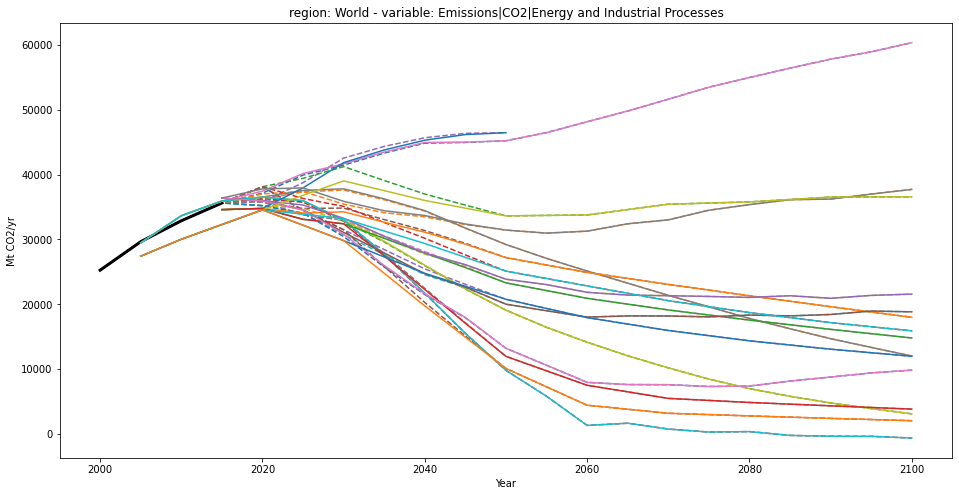

In [23]:
figure = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)

harm_world.filter(variable=co2ind, region="World").plot(ax=ax, linestyle="--")
histall.filter(variable=co2ind, year=harm_world.year).plot(ax=ax, linestyle="-", linewidth=3, color="black")
raw_data.filter(variable=co2ind, region="World").plot(ax=ax, linestyle="-")

In [24]:
# Denote harmonisation in scenario names
harm_world = pyam.IamDataFrame(harm_world).data
harm_world["scenario"] = harm_world["scenario"] + "|Harmonized"
harm_world = pyam.IamDataFrame(harm_world)

In [25]:
# Since we don't have regional info in this case
harm_all = harm_world

In [26]:
# Harmonize sr15 too!
harmable_sr15_vars = [
    'Emissions|BC',
    'Emissions|CH4',
    'Emissions|CO',
    'Emissions|CO2',
    'Emissions|CO2|AFOLU',
    'Emissions|CO2|Energy and Industrial Processes',
    'Emissions|F-Gases',
    'Emissions|N2O',
    'Emissions|NH3',
    'Emissions|NOx',
    'Emissions|OC',
    'Emissions|Sulfur',
    'Emissions|VOC',
]
try:
    del harmed_sr15
except:
    pass
for harmvariable in harmable_sr15_vars:
    to_harm = sr15.filter(variable=harmvariable, scenario=scenstring, region="World").interpolate(2015)
    harmed_sr15_cmpt = harmonize(
        to_harm, harmvariable, histall.filter(region="World"), [2015, 2020, 2030, 2040, 2050])
    try:
        harmed_sr15 = harmed_sr15.append(harmed_sr15_cmpt)
    except: 
        harmed_sr15 = harmed_sr15_cmpt
# Some variables don't exist often enough in the SSP scenarios
fgas_harmvars = [
    'Emissions|SF6',
    'Emissions|HFC',
    'Emissions|PFC',
    'Emissions|PFC|C2F6',
    'Emissions|PFC|CF4'
]
for harmvariable in fgas_harmvars:
    to_harm = sr15.filter(variable=harmvariable, region="World")
    harmed_sr15_cmpt = harmonize(to_harm, harmvariable, histall.filter(region="World"), [2015, 2020, 2030, 2040, 2050])
    harmed_sr15 = harmed_sr15.append(harmed_sr15_cmpt)
# And the gases that exist as subcomponents of HFCs are impossible to harmonise and simply appended. 
harmed_sr15 = harmed_sr15.append(sr15.filter(region="World", variable="*|HFC|*"))

unit mismatch for  ['Mt NOx/yr'] (desired) and ['Mt NO2/yr'] (current) for variable Emissions|NOx
Converted unit of Emissions|NOx to ['Mt NO2/yr']
unit mismatch for  ['Mt CO2-equiv/yr'] (desired) and ['kt HFC134a-equiv/yr'] (current) for variable Emissions|HFC
Converted unit of Emissions|HFC to ['Mt CO2-equiv/yr']
unit mismatch for  ['Mt CO2-equiv/yr'] (desired) and ['kt CF4-equiv/yr'] (current) for variable Emissions|PFC
Converted unit of Emissions|PFC to ['Mt CO2-equiv/yr']


In [27]:
harmed_sr15.filter(variable=co2ind).timeseries().isna().sum() - sr15.filter(variable=co2ind).timeseries().isna().sum()

2000   -1540
2005    -386
2010     -67
2011       0
2012       0
2013       0
2014       0
2015    -424
2016       0
2020       3
2025       0
2030       3
2035       0
2040       3
2045       0
2050       3
2055       0
2060       0
2065       0
2070       0
2075       0
2080       0
2085       0
2090       0
2095       0
2100       0
dtype: int64

In [28]:
kyoto_gases = [co2ind, co2afolu, "Emissions|CH4", "Emissions|N2O", fgas]
for gas in kyoto_gases:
    harmed_sr15.require_variable(exclude_on_fail=True, variable=gas, year=2100)

pyam.core - INFO: 222 scenarios do not include required variable `Emissions|CO2|Energy and Industrial Processes`, marked as `exclude: True` in `meta`
pyam.core - INFO: 224 scenarios do not include required variable `Emissions|CO2|AFOLU`, marked as `exclude: True` in `meta`
pyam.core - INFO: 226 scenarios do not include required variable `Emissions|CH4`, marked as `exclude: True` in `meta`
pyam.core - INFO: 223 scenarios do not include required variable `Emissions|N2O`, marked as `exclude: True` in `meta`
pyam.core - INFO: 464 scenarios do not include required variable `Emissions|F-Gases`, marked as `exclude: True` in `meta`


In [29]:
sr15_ky_ar6 = _construct_consistent_values(aggregate_name=variable, components=kyoto_gases, 
    db_to_generate=convert_units_to_MtCO2_equiv(harmed_sr15.filter(variable=kyoto_gases, exclude=False), metric_name=metric))

In [30]:
assert np.allclose(
    histkyoto.filter(year=2015).data.value, 
    sr15_ky_ar6.filter(year=2015).data.value.unique()
)

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|Kyoto Gases (AR5-GWP100)'}, xlabel='Year', ylabel='Mt CO2-equiv/yr'>

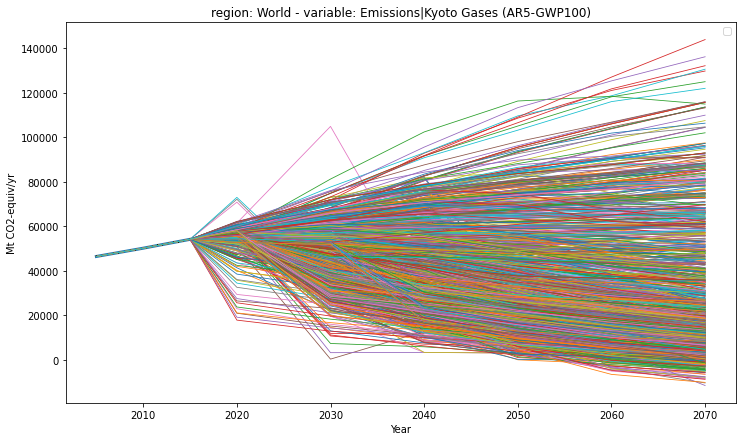

In [31]:
plt.figure(figsize=(12, 7))
ax = plt.subplot()
histkyoto.filter(year=[2005, 2010, 2015]).plot(ax=ax, linewidth=3)
sr15_ky_ar6.filter(year=[2005, 2010, 2015, 2020, 2030, 2040, 2050, 2060, 2070]).plot(ax=ax, linewidth=0.8)

In [32]:
harmed_sr15 = harmed_sr15.append(sr15_ky_ar6)

In [33]:
harmed_sr15.timeseries()

2000  \
model             scenario               region variable                                      unit                            
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|BC                                  Mt BC/yr             7.458000   
                                                Emissions|CH4                                 Mt CH4/yr          310.188077   
                                                Emissions|CO                                  Mt CO/yr           886.589310   
                                                Emissions|CO2                                 Mt CO2/yr        29658.678517   
                                                Emissions|CO2|AFOLU                           Mt CO2/yr         4399.037134   
...                                                                                                                     ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NoPolicy      World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        25259.641383   
                                                Emissions|F-Gases                             Mt CO2-equiv/yr    388.111600   
                                                Emissions|Kyoto Gases (AR5-GWP100)            Mt CO2-equiv/yr  41278.706284   
                                                Emissions|N2O                                 kt N2O/yr         9610.000000   
                                                Emissions|Sulfur                              Mt SO2/yr          111.148729   

                                                                                                                       2005  \
model             scenario               region variable                                      unit                            
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|BC                                  Mt BC/yr             8.840000   
                                                Emissions|CH4                                 Mt CH4/yr          346.395724   
                                                Emissions|CO                                  Mt CO/yr           950.595665   
                                                Emissions|CO2                                 Mt CO2/yr        33413.896429   
                                                Emissions|CO2|AFOLU                           Mt CO2/yr         3755.732166   
...                                                                                                                     ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NoPolicy      World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        29658.164263   
                                                Emissions|F-Gases                             Mt CO2-equiv/yr    526.656700   
                                                Emissions|Kyoto Gases (AR5-GWP100)            Mt CO2-equiv/yr  46422.133404   
                                                Emissions|N2O                                 kt N2O/yr        10500.000000   
                                                Emissions|Sulfur                              Mt SO2/yr          124.980692   

                                                                                                                       2010  \
model             scenario               region variable                                      unit                            
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|BC                                  Mt BC/yr             9.665000   
                                                Emissions|CH4                                 Mt CH4/yr          370.896512   
                                                Emissions|CO                                  Mt CO/yr           953.233297   
                                                Emissions|CO2                                 Mt CO2/yr        36131.477195   
                                                Emiss

In [34]:
# Remove values that are not thought out properly
for var in ["*PFC", "*PFC|CF4", "*SF6"]:
    bad_pfcs = harm_all.filter(variable=var, year=2030).data.iloc[
        [x==0 for x in harm_all.filter(variable=var, year=2030).data["value"]]
    ].model.unique()
    print(f"Bad values for {bad_pfcs}")
    harm_all = harm_all.filter(variable=var, model=bad_pfcs, keep=False)

Bad values for ['GCAM-PR 5.3']
Bad values for []
Bad values for ['GCAM-PR 5.3']


In [35]:
# Unify the regional breakdown of emissions?
"""
def unify_regions_to_totals(df):
    to_return = df.data
    for var in df.variable:
        aggcheck = df.check_aggregate_region(var)
        if aggcheck is not None:
            aggcheck = aggcheck.rename(columns={"region":"whole"}).reset_index()
        else:
            print("no unification possible for {}".format(var))
            continue
        aggcheck["ratio"] = aggcheck.loc[:, "whole"] / aggcheck.loc[:, "subregions"]
        
        for ind, (model, scenario, year) in aggcheck[["model", "scenario", "year"]].iterrows():
            to_return.loc[
                (to_return["region"]!="World") & (to_return["model"]==model) 
                & (to_return["scenario"]==scenario)
                & (to_return["variable"]==var) & (to_return["year"]==year), "value"
            ] *= aggcheck.loc[ind, "ratio"]
        print("Unified {} with ratio {}".format(
            var, aggcheck.loc[ind, "ratio"]))
    return pyam.IamDataFrame(to_return)

histall_unify = unify_regions_to_totals(histall)
"""
histall_unify = histall

In [36]:
harmed_sr15.filter(variable="Emissions|HFC|HFC*").variable

['Emissions|HFC|HFC125',
 'Emissions|HFC|HFC134a',
 'Emissions|HFC|HFC143a',
 'Emissions|HFC|HFC227ea',
 'Emissions|HFC|HFC23',
 'Emissions|HFC|HFC32',
 'Emissions|HFC|HFC43-10',
 'Emissions|HFC|HFC245fa']

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


(2005.0, 2060.0)

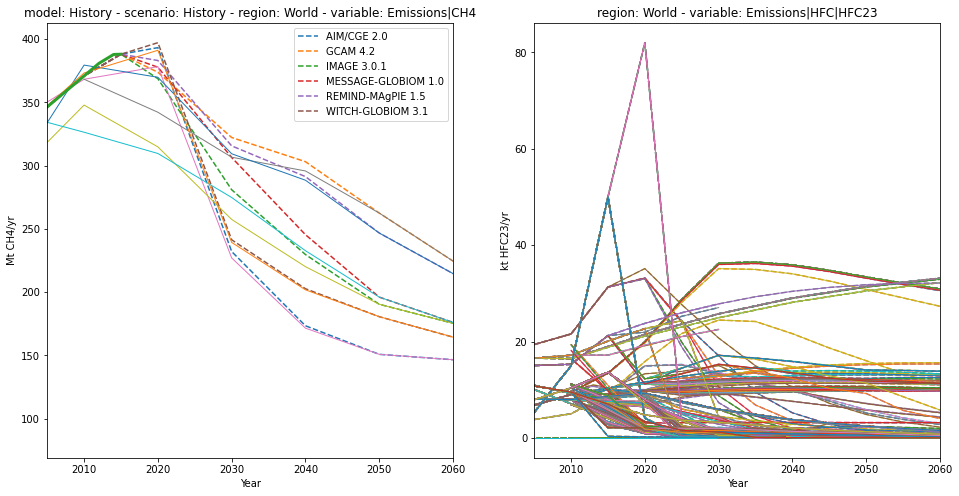

In [37]:
figure = plt.figure(figsize=(16, 8))
ax = plt.subplot(121)
harmed_sr15.filter(variable="Emissions|CH4", scenario="SSP1-2*", region="World").plot(ax=ax, linestyle="--")
sr15.filter(variable="Emissions|CH4", scenario="SSP1-2*", region="World").plot(ax=ax, linewidth=1)
histall.filter(variable="Emissions|CH4", region="World").plot(ax=ax, linewidth=3)
plt.xlim([2005, 2060])
ax = plt.subplot(122)
harmed_sr15.filter(variable="Emissions|HFC|HFC23", region="World").plot(ax=ax, linestyle="--")
sr15.filter(variable="Emissions|HFC|HFC23", region="World").plot(ax=ax, linewidth=1)
plt.xlim([2005, 2060])

Text(2000, 20000, 'expect change if correcting regions')

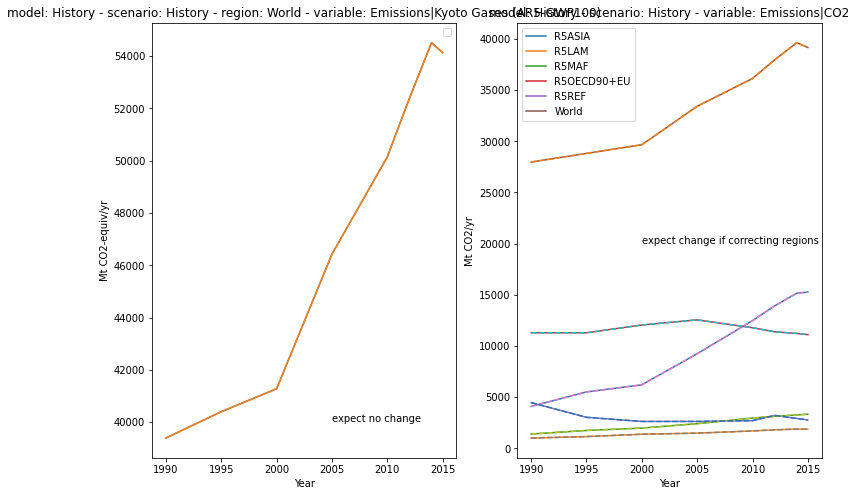

In [38]:
ch4 = "Emissions|CH4"
plt.figure(figsize=(12, 8))
ax = plt.subplot(121)
histall_unify.filter(variable=variable).plot(ax=ax)
histall.filter(variable=variable).plot(ax=ax)
plt.text(x=2005, y=40000, s="expect no change")
ax = plt.subplot(122)
histall_unify.filter(variable=co2).plot(ax=ax)
histall.filter(variable=co2).plot(ax=ax, linestyle="--")
plt.text(x=2000, y=20000, s="expect change if correcting regions")

# Plot distribution of 2030 values

In [39]:
harm_all_but_old_names = harm_all.filter(variable=co2ind, region="World", year=2030).data
harm_all_but_old_names["scenario"] = harm_all_but_old_names["scenario"].str.replace(
    "\|Harmonized", "")
compare_harms_ky = pd.merge(
    raw_data.filter(variable=co2ind, region="World", year=2030).data,
    harm_all_but_old_names,
    on=("model", "scenario", "region", "year", "variable", "unit"),
    how="outer"
)
compare_harms_ky = compare_harms_ky.rename(columns={"value_x": "Unharmonized", "value_y": "Harmonized"})

C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
histkyoto.timeseries()

,,,,,1990,1995,2000,2005,2010,2012,2014,2015
model,scenario,region,variable,unit,,,,,,,,
History,History,World,Emissions|Kyoto Gases (AR5-GWP100),Mt CO2-equiv/yr,39395.3975,40401.621046,41278.706284,46422.133404,50141.447145,52379.728867,54509.358091,54125.849662


Text(0.5, 20.799999999999983, 'Unharmonized 2030 Kyoto total (Mt CO2)')

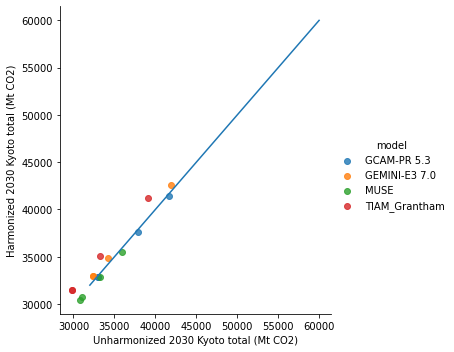

In [41]:
sns.lmplot(x='Unharmonized', y='Harmonized', data=compare_harms_ky, hue='model', fit_reg=False)
plt.plot([32000, 60000], [32000, 60000])
plt.ylabel("Harmonized 2030 Kyoto total (Mt CO2)")
plt.xlabel("Unharmonized 2030 Kyoto total (Mt CO2)")

In [42]:
compare_harms_ky = compare_harms_ky.melt(
    [c for c in compare_harms_ky.columns if c not in ["Unharmonized", "Harmonized"]], var_name="Harmonization"
)
compare_harms_ky.head()

,model,scenario,region,variable,unit,year,Harmonization,value
0,GCAM-PR 5.3,Baseline,World,Emissions|CO2|Energy and Industrial Processes,Mt CO2/yr,2030,Unharmonized,41679.368757
1,GCAM-PR 5.3,CP_EI,World,Emissions|CO2|Energy and Industrial Processes,Mt CO2/yr,2030,Unharmonized,37819.643396
2,GCAM-PR 5.3,NDC_EI,World,Emissions|CO2|Energy and Industrial Processes,Mt CO2/yr,2030,Unharmonized,32988.868727
3,GCAM-PR 5.3,NDC_LTS,World,Emissions|CO2|Energy and Industrial Processes,Mt CO2/yr,2030,Unharmonized,32988.868842
4,GEMINI-E3 7.0,Baseline,World,Emissions|CO2|Energy and Industrial Processes,Mt CO2/yr,2030,Unharmonized,41863.195000


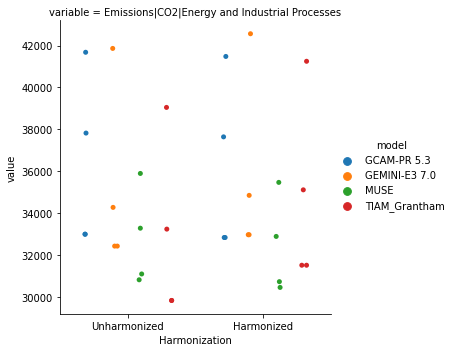

In [43]:
sns.catplot(x="Harmonization", y="value", col="variable", hue="model", 
            data=compare_harms_ky, dodge=True)

# Clean some bad values from AR6 database

In [44]:
ch4ts = harmed_sr15.filter(variable="Emissions|CH4").timeseries()
bad = ch4ts.loc[ch4ts[2100] > 500 * ch4ts[2100].median(), :].reset_index().loc[:, ["model", "scenario"]]
bad

,model,scenario
0,TIAM-UCL 4.1.1,SSP2_1_5D-50_CCC2020
1,TIAM-UCL 4.1.1,SSP2_1_75D-66_CCC2020
2,TIAM-UCL 4.1.1,SSP2_2D-66_CCC2020
3,TIAM-UCL 4.1.1,SSP2_BASE_CCC2020


In [45]:
for item in bad.iterrows():
    harmed_sr15 = harmed_sr15.filter(model=item[1]["model"], scenario=item[1]["scenario"], variable="*CH4", keep=False)

# Output harmonised values

In [46]:
out_folder = "../output/processed_files/"
harm_all.to_csv(out_folder + f"harm_all_{version}.csv")
harmed_sr15.to_csv(out_folder + "ar6_cleaned_harmed.csv")

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|CH4'}, xlabel='Year', ylabel='Mt CH4/yr'>

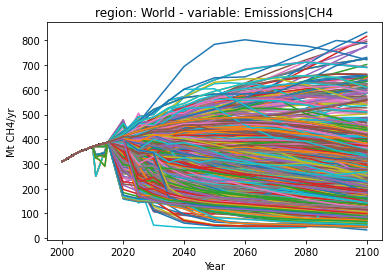

In [47]:
harmed_sr15.filter(variable="*CH4").plot()